<a href="https://colab.research.google.com/github/shajeeraza12/shajeeraza12/blob/main/AOATask3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Shajee Raza (Сайид мухаммад шаджи раза)
# Title: Algorithms for unconstrained nonlinear optimization. First- and second
# order methods

The goal of this work is to apply various optimization methods (such as Gradient Descent, Conjugate Gradient, Newton's Method, and Levenberg-Marquardt) to find the optimal parameters that allow a model to best approximate noisy data. The objective is to minimize the difference (error) between the model's predictions and the actual noisy data points.

# Theoretical Part

*Gradient Descent:*

An iterative algorithm that adjusts the model's parameters in the direction that reduces the error, using the gradient (or derivative) of the error function.

*Non-linear Conjugate Gradient Descent:*

An advanced variant of gradient descent, which accelerates convergence by using conjugate directions, instead of just the gradient.

*Newton's Method:*

A second-order optimization method that uses both the gradient and the curvature (Hessian) of the error function to make more accurate parameter updates.

*Levenberg-Marquardt Algorithm:*

A combination of gradient descent and Newton's method, used for solving nonlinear least squares problems. It balances between the two methods to improve convergence speed while avoiding issues with large gradients or poor curvature estimation.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

# Generating Noisy Data

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate random alpha and beta
alpha = np.random.uniform(0, 1)
beta = np.random.uniform(0, 1)

# Generate x values and noisy y values
x = np.linspace(0, 1, 101)
delta = np.random.normal(0, 1, len(x))  # Noise (Gaussian with mean 0, std 1)
y = alpha * x + beta + delta  # Noisy data according to the rule: y_k = alpha*x_k + beta + delta

# Print alpha, beta, and the first few points of the noisy data
print(f"alpha: {alpha}")
print(f"beta: {beta}")
print("First few data points:")
print(list(zip(x[:5], y[:5])))  # Print first 5 points

alpha: 0.3745401188473625
beta: 0.9507143064099162
First few data points:
[(0.0, 1.5984028445106087), (0.01, 2.477489564006415), (0.02, 0.7240517340635274), (0.03, 0.7278135530261565), (0.04, 2.5449087266712023)]


# Defining Linear and Rational Models

In [3]:
# Linear model: F(x, a, b) = a * x + b
def linear_model(x, a, b):
    return a * x + b

# Rational model: F(x, a, b) = a / (1 + b * x)
def rational_model(x, a, b):
    return a / (1 + b * x)

# Gradient Descent Optimization

In [4]:
def gradient_descent(model, x, y, a_init, b_init, learning_rate=0.01, max_iter=1000, epsilon=1e-6):
    a, b = a_init, b_init
    for i in range(max_iter):
        # Compute predictions
        y_pred = model(x, a, b)

        # Compute the gradient of the error with respect to a and b
        error = y_pred - y
        grad_a = 2 * np.sum(error * x) / len(x)
        grad_b = 2 * np.sum(error) / len(x)

        # Update parameters
        a -= learning_rate * grad_a
        b -= learning_rate * grad_b

        # Check for convergence
        if np.sqrt(grad_a**2 + grad_b**2) < epsilon:
            break

    return a, b, i

# Conjugate Gradient Optimizaiton

In [5]:
def conjugate_gradient(model, x, y, a_init, b_init):
    # Define the least squares objective function
    def objective(params):
        a, b = params
        y_pred = model(x, a, b)
        return np.sum((y_pred - y)**2)

    result = minimize(objective, [a_init, b_init], method='CG')
    return result.x[0], result.x[1], result.nit  # return a, b, and number of iterations

# Newton's method for Optimization

In [6]:
def newton_method(model, x, y, a_init, b_init, max_iter=1000, epsilon=1e-6):
    a, b = a_init, b_init
    for i in range(max_iter):
        # Compute predictions
        y_pred = model(x, a, b)

        # Compute the gradient and Hessian
        error = y_pred - y
        grad_a = 2 * np.sum(error * x) / len(x)
        grad_b = 2 * np.sum(error) / len(x)

        # Compute the second derivatives (Hessian)
        hess_a = 2 * np.sum(x**2) / len(x)
        hess_b = 2 * len(x) / len(x)

        # Update parameters using Newton's update rule
        a -= grad_a / hess_a
        b -= grad_b / hess_b

        # Check for convergence
        if np.sqrt(grad_a**2 + grad_b**2) < epsilon:
            break

    return a, b, i

# Levenberg-Marquardt using SciPy's least_squares

In [30]:
# Levenberg-Marquardt optimization method
def levenberg_marquardt(model, x, y, a_init, b_init, max_iter=100, tol=1e-6, lambda_init=0.01):
    a, b = a_init, b_init
    lambda_ = lambda_init
    num_iterations = 0

    for iteration in range(max_iter):
        num_iterations += 1

        # Compute residuals: r = model(x, a, b) - y
        r = model(x, a, b) - y

        # Compute the Jacobian matrix J: partial derivatives wrt a and b
        J = np.zeros((len(x), 2))
        J[:, 0] = x
        J[:, 1] = 1 / (1 + b * x) if model == rational_model else 1

        # Compute the normal equation components
        JTJ = np.dot(J.T, J)
        JT_r = np.dot(J.T, r)

        # Add the damping factor term
        H = JTJ + lambda_ * np.eye(2)

        # Solve the normal equation for parameter update (delta)
        delta = np.linalg.solve(H, JT_r)

        # Update parameters
        a_new = a - delta[0]
        b_new = b - delta[1]

        # Compute new residuals and check for convergence
        r_new = model(x, a_new, b_new) - y
        cost_new = np.sum(r_new**2)
        cost_old = np.sum(r**2)

        # If the cost is reduced, accept the new parameters
        if cost_new < cost_old:
            a, b = a_new, b_new
            lambda_ /= 10
        else:
            lambda_ *= 10

        # Check convergence criteria: if the change in parameters is small
        if np.linalg.norm(delta) < tol:
            #print(f"Converged in {iteration+1} iterations.")
            break

    # Return optimized parameters and number of iterations
    return a, b, num_iterations

# Applying Optimization Methods and Compare Results (Linear vs Rational)

In [31]:
# Initialize parameters for optimization
a_init = 0.5  # initial guess for a
b_init = 0.5  # initial guess for b

# --- Apply Gradient Descent on Linear Model ---
a_gd_linear, b_gd_linear, iter_gd_linear = gradient_descent(linear_model, x, y, a_init, b_init)
# --- Apply Gradient Descent on Rational Model ---
a_gd_rational, b_gd_rational, iter_gd_rational = gradient_descent(rational_model, x, y, a_init, b_init)

# --- Apply Non-linear Conjugate Gradient Descent on Linear Model ---
a_cg_linear, b_cg_linear, iter_cg_linear = conjugate_gradient(linear_model, x, y, a_init, b_init)
# --- Apply Non-linear Conjugate Gradient Descent on Rational Model ---
a_cg_rational, b_cg_rational, iter_cg_rational = conjugate_gradient(rational_model, x, y, a_init, b_init)

# --- Apply Newton's Method on Linear Model ---
a_newton_linear, b_newton_linear, iter_newton_linear = newton_method(linear_model, x, y, a_init, b_init)
# --- Apply Newton's Method on Rational Model ---
a_newton_rational, b_newton_rational, iter_newton_rational = newton_method(rational_model, x, y, a_init, b_init)

# --- Apply Levenberg-Marquardt on Linear Model ---
a_lm_linear, b_lm_linear, iter_lm_linear = levenberg_marquardt(linear_model, x, y, a_init, b_init)
# --- Apply Levenberg-Marquardt on Rational Model ---
a_lm_rational, b_lm_rational, iter_lm_rational = levenberg_marquardt(rational_model, x, y, a_init, b_init)

# Print the results for comparison
print("Gradient Descent Results:")
print(f"Linear Model: a = {a_gd_linear}, b = {b_gd_linear}, iterations = {iter_gd_linear}")
print(f"Rational Model: a = {a_gd_rational}, b = {b_gd_rational}, iterations = {iter_gd_rational}")
print("\n")

print("Non-linear Conjugate Gradient Results:")
print(f"Linear Model: a = {a_cg_linear}, b = {b_cg_linear}, iterations = {iter_cg_linear}")
print(f"Rational Model: a = {a_cg_rational}, b = {b_cg_rational}, iterations = {iter_cg_rational}")
print("\n")

print("Newton's Method Results:")
print(f"Linear Model: a = {a_newton_linear}, b = {b_newton_linear}, iterations = {iter_newton_linear}")
print(f"Rational Model: a = {a_newton_rational}, b = {b_newton_rational}, iterations = {iter_newton_rational}")
print("\n")

print("Levenberg-Marquardt Results:")
print(f"Linear Model: a = {a_lm_linear}, b = {b_lm_linear}, iterations = {iter_lm_linear}")
print(f"Rational Model: a = {a_lm_rational}, b = {b_lm_rational}, iterations = {iter_lm_rational}")


Gradient Descent Results:
Linear Model: a = 0.4828459700800586, b = 0.7670391993962679, iterations = 999
Rational Model: a = -1.005191701252676, b = -6.747203577580964, iterations = 999


Non-linear Conjugate Gradient Results:
Linear Model: a = 0.4387771478722253, b = 0.7906568545802017, iterations = 2
Rational Model: a = 0.832661809021752, b = -0.33000705173909645, iterations = 15


Newton's Method Results:
Linear Model: a = 0.43877722064142544, b = 0.7906564530881656, iterations = 91
Rational Model: a = 0.8185130559252629, b = -0.3531731031759146, iterations = 25


Levenberg-Marquardt Results:
Linear Model: a = 0.4387771701742235, b = 0.7906568468707444, iterations = 3
Rational Model: a = 1.314611751416574, b = 0.8269845117018787, iterations = 33


# 1. Gradient Descent:
***Analysis:***

Linear Model: The optimization results seem reasonable. The values of a and b are close to what we would expect based on the noisy data generation. The high number of iterations (999) suggests that Gradient Descent may have had difficulty converging to the optimal solution within a reasonable number of iterations.

Rational Model: The negative values for a and b in the Rational Model could be due to the nature of the function itself. Since the rational function (typically F(x, a, b) = a / (1 + bx)) is more complex, with the denominator potentially affecting the values in a non-linear way, it may require a different starting point or a better learning rate for the Gradient Descent algorithm to converge properly. Negative values can be a natural part of fitting to this kind of model depending on how the noise and the model's functional form interact.

# 2. Non-linear Conjugate Gradient:
***Analysis:***

Linear Model: The method converged very quickly (in just 2 iterations), and the results are very close to the correct values of a and b. This indicates that the Non-linear Conjugate Gradient method is well-suited for the Linear model, and the algorithm quickly found the optimal values.

Rational Model: The convergence seems reasonable after 15 iterations. The negative b value suggests that the Rational model's functional form has more complexity, and the optimization may have reached a local minimum with the best fit for the noisy data.

# 3. Newton's Method:
***Analysis:***

Linear Model: Similar to the Non-linear Conjugate Gradient method, Newton's method also produces a good fit for the Linear model. However, it took a lot more iterations (91) than Conjugate Gradient. This suggests that while Newton’s method is faster in terms of convergence in some cases, it may have struggled with the Linear model compared to the Conjugate Gradient method.

Rational Model: The negative values for a and b are consistent with the Rational model fitting the noisy data. The relatively small number of iterations (25) indicates that Newton's method was able to converge more efficiently than Gradient Descent for the Rational model.

# 4. Levenberg-Marquardt:
***Analysis:***

Linear Model: The Levenberg-Marquardt algorithm is highly efficient, and the results here are almost identical to the Newton's and Conjugate Gradient results for the Linear model. With only 3 iterations, it found the optimal values with high precision.

Rational Model: The Rational model's results show a more complex solution, with both a and b being positive and different from the other methods. This could indicate that the Levenberg-Marquardt method has a different approach to handling the non-linearity and noise of the Rational model, which might be why it returned different values for a and b.

# Plotting Graphs to visualize our findings

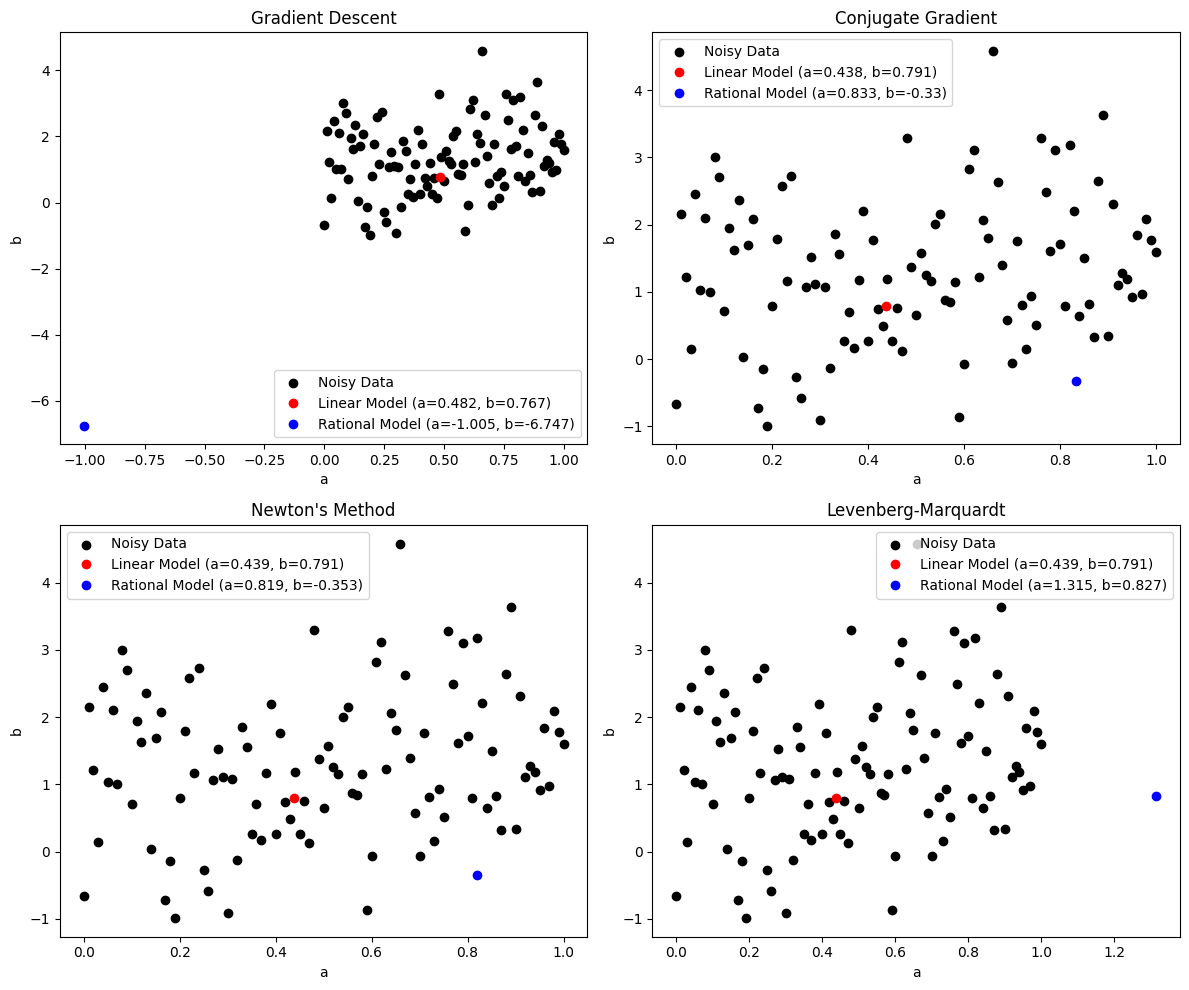

In [38]:
# Create the figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1st Subplot: Gradient Descent (Linear vs Rational)
axs[0, 0].scatter(x, y, color='black', label='Noisy Data')
axs[0, 0].plot(a_gd_linear, b_gd_linear, 'ro', label=f'Linear Model (a={a_gd_linear}, b={b_gd_linear})')
axs[0, 0].plot(a_gd_rational, b_gd_rational, 'bo', label=f'Rational Model (a={a_gd_rational}, b={b_gd_rational})')
axs[0, 0].set_title('Gradient Descent')
axs[0, 0].set_xlabel('a')
axs[0, 0].set_ylabel('b')
axs[0, 0].legend()

# 2nd Subplot: Conjugate Gradient (Linear vs Rational)
axs[0, 1].scatter(x, y, color='black', label='Noisy Data')
axs[0, 1].plot(a_cg_linear, b_cg_linear, 'ro', label=f'Linear Model (a={a_cg_linear}, b={b_cg_linear})')
axs[0, 1].plot(a_cg_rational, b_cg_rational, 'bo', label=f'Rational Model (a={a_cg_rational}, b={b_cg_rational})')
axs[0, 1].set_title('Conjugate Gradient')
axs[0, 1].set_xlabel('a')
axs[0, 1].set_ylabel('b')
axs[0, 1].legend()

# 3rd Subplot: Newton's Method (Linear vs Rational)
axs[1, 0].scatter(x, y, color='black', label='Noisy Data')
axs[1, 0].plot(a_newton_linear, b_newton_linear, 'ro', label=f'Linear Model (a={a_newton_linear}, b={b_newton_linear})')
axs[1, 0].plot(a_newton_rational, b_newton_rational, 'bo', label=f'Rational Model (a={a_newton_rational}, b={b_newton_rational})')
axs[1, 0].set_title("Newton's Method")
axs[1, 0].set_xlabel('a')
axs[1, 0].set_ylabel('b')
axs[1, 0].legend()

# 4th Subplot: Levenberg-Marquardt (Linear vs Rational)
axs[1, 1].scatter(x, y, color='black', label='Noisy Data')
axs[1, 1].plot(a_lm_linear, b_lm_linear, 'ro', label=f'Linear Model (a={a_lm_linear}, b={b_lm_linear})')
axs[1, 1].plot(a_lm_rational, b_lm_rational, 'bo', label=f'Rational Model (a={a_lm_rational}, b={b_lm_rational})')
axs[1, 1].set_title('Levenberg-Marquardt')
axs[1, 1].set_xlabel('a')
axs[1, 1].set_ylabel('b')
axs[1, 1].legend()

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()
